**a. Installation et importation des bibliothèques nécessaires**

In [1]:
pip install pandas numpy wordcloud textblob nltk sklearns

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearns (from versions: none)
ERROR: No matching distribution found for sklearns


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
from sklearn.cluster import KMeans
import nltk

#nltk.download('stopwords')

**b. Chargement et préparation des données**

In [3]:
# Charger le dataset
df = pd.read_csv('fashionnova_reviews.csv')

# on affiche les infos sur les données et le debut du dataset 
df.head()

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
0,Champagne,/users/66c78240087b6269ffbcb5fb,US,1 review,2024-08-22T20:24:02.000Z,Rated 5 out of 5 stars,I love ordering from fashion nova,I love ordering from fashion nova. The clothes...,"August 22, 2024"
1,Vg customer,/users/6618fdb53d4198001210cbe7,VG,3 reviews,2024-08-21T05:43:11.000Z,Rated 5 out of 5 stars,Top tier content for fashion nova,Always amazing clothes and the fast shipping i...,"August 18, 2024"
2,Colleen Burgher,/users/64e9595206be1a001244ff73,US,3 reviews,2024-08-21T17:09:14.000Z,Rated 5 out of 5 stars,Prices and quality of products are…,Prices and quality of products are GREAT Would...,"August 21, 2024"
3,R.G.M,/users/66c58ad1c6ab36352a08f57a,US,1 review,2024-08-21T08:36:03.000Z,Rated 5 out of 5 stars,Great customer service,Great customer service. I was helped until the...,"August 20, 2024"
4,Rosalyn Cousar,/users/60ad4b6ef3788e001adbb8e3,US,5 reviews,2024-08-22T00:46:16.000Z,Rated 3 out of 5 stars,False advertising,Disappointing experience. You don’t live up to...,"August 21, 2024"


In [4]:
# Nettoyer les données (dans un premier temps on va supprimer certaines valeurs manquantes)
df = df.dropna(subset=['Review Text', 'Rating'])

# Remplacer les valeurs manquantes
df['Country'] = df['Country'].fillna('Unknown')
df['Reviewer Name'] = df['Reviewer Name'].fillna('Unknown')
df['Review Title'] = df['Review Title'].fillna('No Title')

# vu que les dates ne sont pas au bon format on Convertit les colonnes de date en format datetime
df['Review Date'] = pd.to_datetime(df['Review Date'])
df['Date of Experience'] = pd.to_datetime(df['Date of Experience'])

# Extraire le mois et l'année de la colonne 'Review Date'
df['Review Month'] = df['Review Date'].dt.to_period('M')



# enfin on extrait la note (nombre d'étoiles) à partir de la colonne Rating
df['Stars'] = df['Rating'].str.extract(r'(\d+)').astype(int)
#nombre de valeurs manquantes par colonne

missing_values = df.isnull().sum()
print(missing_values)

C:\Users\pc cam\AppData\Local\Temp\ipykernel_16252\724610179.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Review Date'] = pd.to_datetime(df['Review Date'])
C:\Users\pc cam\AppData\Local\Temp\ipykernel_16252\724610179.py:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Review Month'] = df['Review Date'].dt.to_period('M')


Reviewer Name         0
Profile Link          0
Country               0
Review Count          0
Review Date           0
Rating                0
Review Title          0
Review Text           0
Date of Experience    0
Review Month          0
Stars                 0
dtype: int64


**c. Analyse Exploratoire**

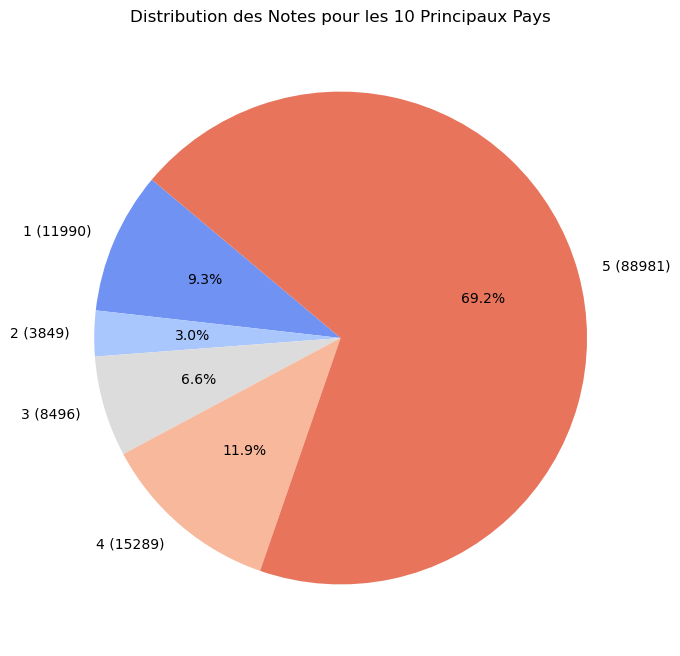

In [5]:
# Filtrer les 10 pays avec le plus grand nombre de notes
top_countries = df['Country'].value_counts().head(10).index
filtered_df = df[df['Country'].isin(top_countries)]

# Calculer la distribution des notes pour ces pays
note_distribution = filtered_df.groupby('Country')['Stars'].value_counts().unstack().fillna(0)

# Préparer les données pour le graphique
note_distribution = note_distribution.sum(axis=0)  # Somme des notes pour chaque catégorie
labels = [f'{note} ({count})' for note, count in note_distribution.items()]

# Définir une palette de couleurs
palette = sns.color_palette('coolwarm', n_colors=len(note_distribution))

# Créer le graphique en camembert
plt.figure(figsize=(10, 8))
plt.pie(note_distribution, labels=labels, autopct='%1.1f%%', colors=palette, startangle=140)
plt.title('Distribution des Notes pour les 10 Principaux Pays')
plt.show()

C:\Users\pc cam\AppData\Local\Temp\ipykernel_16252\3045799143.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Country', y='Stars', data=filtered_df, palette='viridis', inner=None)


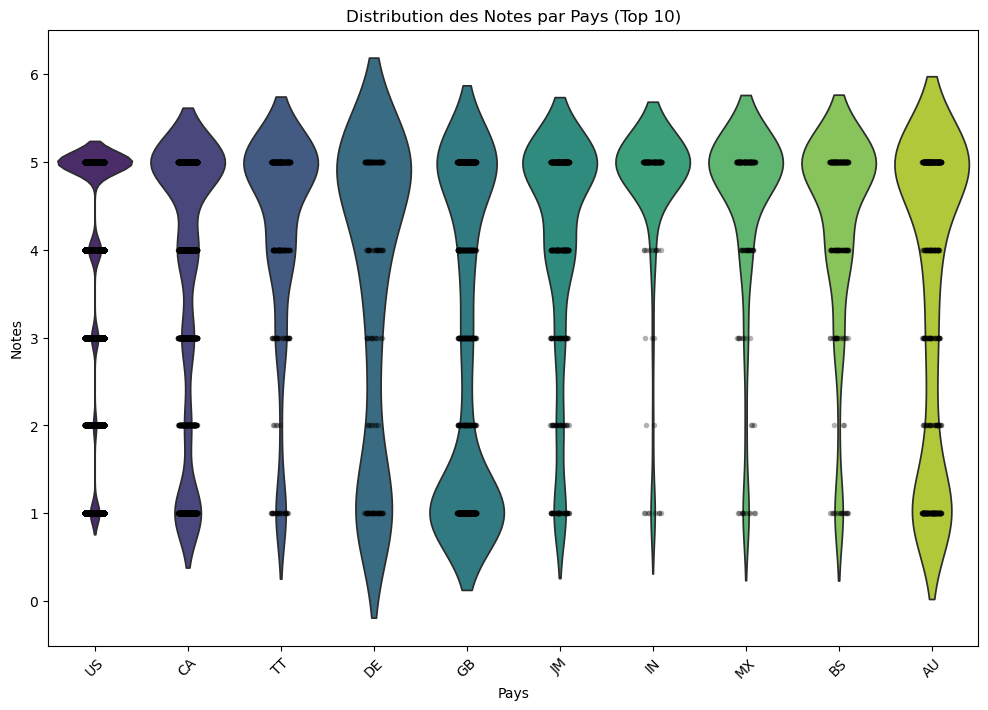

In [6]:
# Filtrer les 10 pays avec le plus grand nombre de notes
top_countries = df['Country'].value_counts().head(10).index
filtered_df = df[df['Country'].isin(top_countries)]

# Créer le graphique en violon
plt.figure(figsize=(12, 8))
sns.violinplot(x='Country', y='Stars', data=filtered_df, palette='viridis', inner=None)

# Ajouter des points pour la densité des notes
sns.stripplot(x='Country', y='Stars', data=filtered_df, color='k', alpha=0.3, size=4, jitter=True)

plt.title('Distribution des Notes par Pays (Top 10)')
plt.xlabel('Pays')
plt.ylabel('Notes')
plt.xticks(rotation=45)
plt.show()

**d. Analyse des sentiments**

C:\Users\pc cam\AppData\Local\Temp\ipykernel_16252\2853990974.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm')


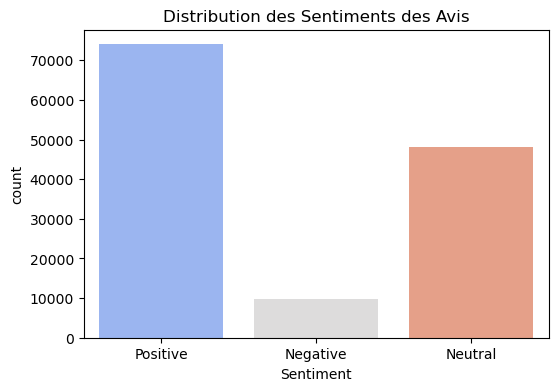

In [7]:
# definissons une Fonction pour analyser les sentiments
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Appliquons maintenant l'analyse des sentiments
df['Sentiment'] = df['Review Text'].apply(get_sentiment)

# Distribution des sentiments
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title('Distribution des Sentiments des Avis')
plt.show()

**d. Analyse des mots-clés**

<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
C:\Users\pc cam\AppData\Local\Temp\ipykernel_16252\2749729056.py:3: SyntaxWarning: invalid escape sequence '\w'
  df['Cleaned Text'] = df['Review Text'].str.lower().str.replace('[^\w\s]','')


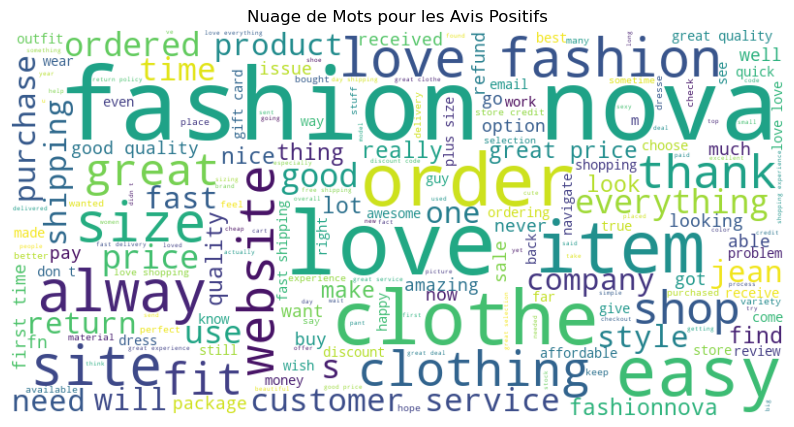

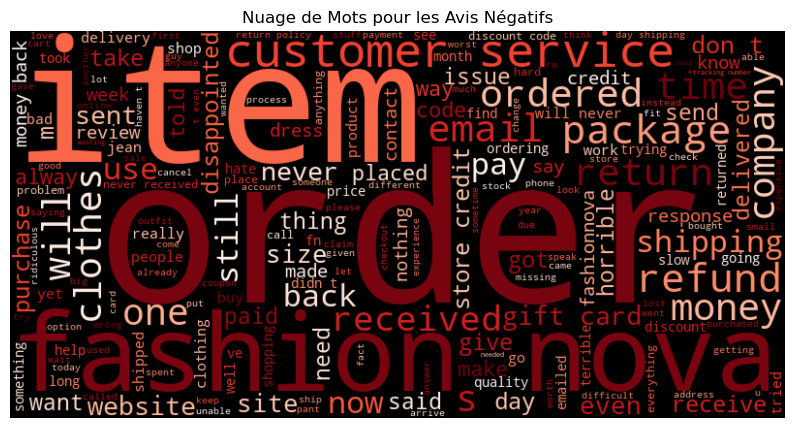

In [8]:
# Préparer le texte pour l'analyse des mots-clés pour distinguer les avis positifs des avis négatifs 
stop_words = set(stopwords.words('english'))
df['Cleaned Text'] = df['Review Text'].str.lower().str.replace('[^\w\s]','')

# Fonction pour extraire les mots-clés
def extract_keywords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words

# Appliquer l'extraction des mots-clés
df['Keywords'] = df['Cleaned Text'].apply(extract_keywords)

# Générer un nuage de mots pour les avis positifs
positive_text = ' '.join(df[df['Sentiment'] == 'Positive']['Cleaned Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots pour les Avis Positifs')
plt.show()

# Nuage de mots pour les avis négatifs
negative_text = ' '.join(df[df['Sentiment'] == 'Negative']['Cleaned Text'])
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots pour les Avis Négatifs')
plt.show()

**f. Analyse temporelle**

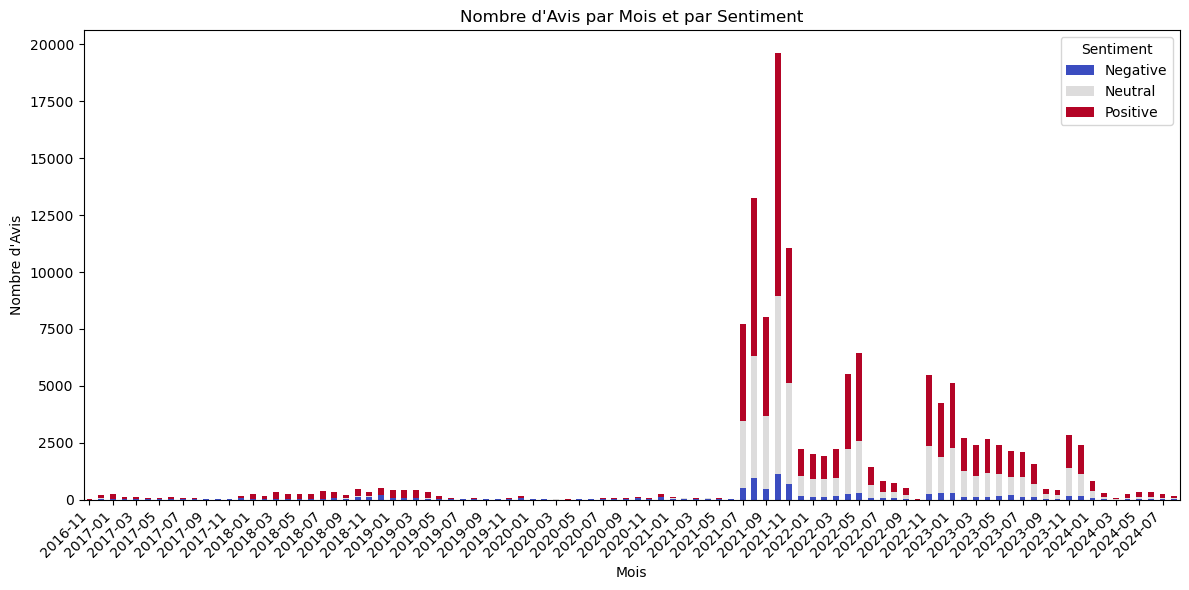

In [9]:
# Ajouter une colonne pour les catégories de sentiments
df['Sentiment'] = df['Review Text'].apply(get_sentiment)

# Créer une table de contingence pour les sentiments par mois
pivot_table = df.pivot_table(index='Review Month', columns='Sentiment', aggfunc='size', fill_value=0)

# Créer le graphique en barres empilées
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')

# Ajuster les étiquettes de l'axe x
plt.title('Nombre d\'Avis par Mois et par Sentiment')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'Avis')

# Rotation et format des dates
ax.set_xticks(ax.get_xticks()[::2])  # Afficher une étiquette sur deux
ax.set_xticklabels([str(tick) for tick in pivot_table.index[::2]])  # Utiliser simplement les mois comme chaîne de caractères

plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes des mois pour meilleure lisibilité
plt.legend(title='Sentiment')
plt.tight_layout()  # Ajuster automatiquement les paramètres de sous-figures pour éviter le chevauchement
plt.show()

**e. Définition de l'Indice de Désirabilité**

**L'indice de désirabilité** pourrait être défini comme une combinaison pondérée des éléments suivants :

- Note (étoiles) : Une évaluation directe du produit ou du service, sur une échelle de 1 à 5.
- Sentiment : Une analyse du ton de l'avis (positif, négatif, neutre).
- Longueur de l'avis : Une mesure du détail dans l'avis, car un avis plus long pourrait indiquer un engagement plus profond, qu'il soit positif ou négatif.

**Matrice de correlation**

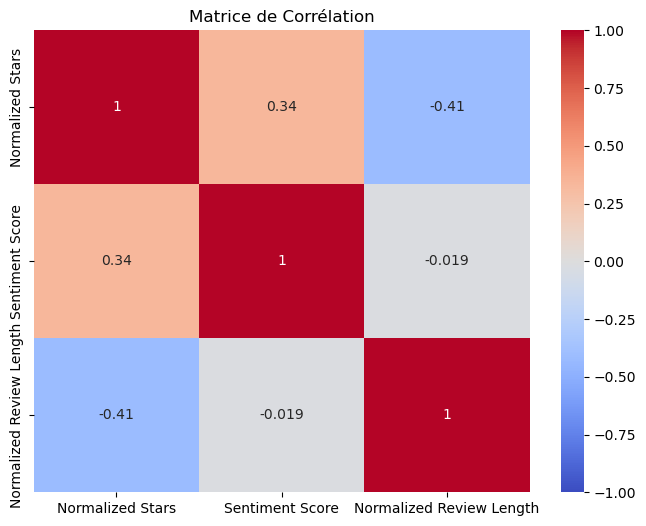

In [10]:

# Sélectionner les colonnes pertinentes pour l'analyse
columns = ['Normalized Stars', 'Sentiment Score', 'Normalized Review Length']

# Normalisation de la note sur une échelle de 0 à 1
df['Normalized Stars'] = df['Stars'] / 5

# Conversion des sentiments en scores
sentiment_mapping = {'Positive': 1, 'Neutral': 0.5, 'Negative': 0}
df['Sentiment Score'] = df['Sentiment'].map(sentiment_mapping)

# Longueur de l'avis
df['Review Length'] = df['Review Text'].apply(lambda x: len(x.split()))
# Normalisation de la longueur de l'avis sur une échelle de 0 à 1
df['Normalized Review Length'] = df['Review Length'] / df['Review Length'].max()

# Calculer la matrice de corrélation
corr_matrix = df[columns].corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()


**Création de l'indice**

In [11]:
# Prendre les valeurs absolues des corrélations avec chaque variable
abs_corr = corr_matrix.abs()

# Calculer la somme des corrélations pour chaque variable (somme des valeurs absolues des corrélations)
weight_sums = abs_corr.sum()

# Normaliser les poids pour qu'ils totalisent 1
weights = weight_sums / weight_sums.sum()

# Calculer l'indice de désirabilité en utilisant les poids basés sur les corrélations
df['Desirability Index'] = (
    weights['Normalized Stars'] * df['Normalized Stars'] +
    weights['Sentiment Score'] * df['Sentiment Score'] +
    weights['Normalized Review Length'] * df['Normalized Review Length']
)

**Interprétation de l'indice**

L'indice de désirabilité est compris entre 0 et 1 :

- 0 : Indique une très faible désirabilité (évaluations faibles, sentiments négatifs, avis courts).
- 1 : Indique une très haute désirabilité (évaluations élevées, sentiments positifs, avis détaillés).

**Visualisation et analyse de l'indice**

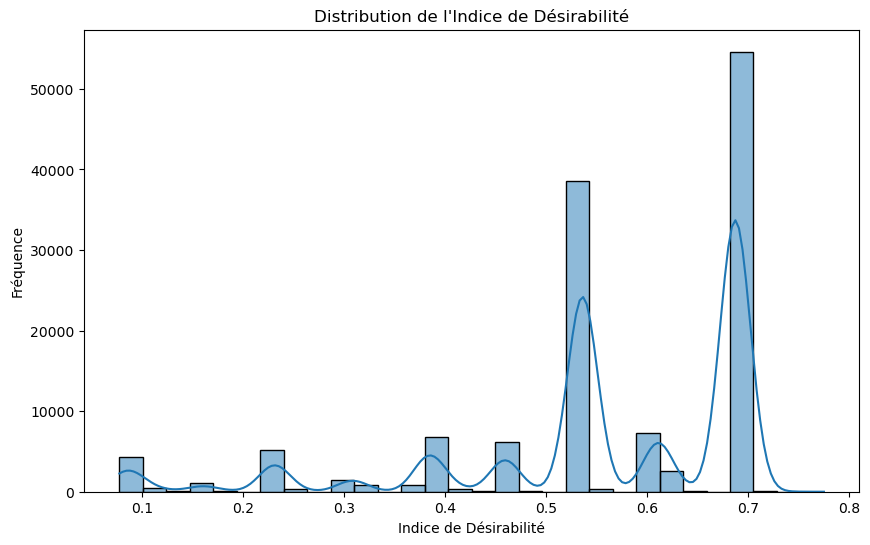

In [12]:
# Visualiser la distribution de l'indice de désirabilité
plt.figure(figsize=(10, 6))
sns.histplot(df['Desirability Index'], bins=30, kde=True)
plt.title('Distribution de l\'Indice de Désirabilité')
plt.xlabel('Indice de Désirabilité')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
# Définir un seuil pour regrouper les pays avec peu d'avis
threshold = 20  # Par exemple, regrouper les pays avec moins de 20 avis

# Créer une nouvelle colonne pour regrouper les petits pays
df['Country Grouped'] = df['Country'].apply(lambda x: x if df['Country'].value_counts()[x] > threshold else 'Autres')

# Créer le graphique
plt.figure(figsize=(14, 8))  # Augmenter la taille de la figure
sns.barplot(x='Country Grouped', y='Desirability Index', data=df, estimator='mean', palette='viridis')

# Ajouter des labels et un titre clairs
plt.title('Indice de Désirabilité Moyen par Pays (avec regroupement)', fontsize=16)
plt.xlabel('Pays', fontsize=14)
plt.ylabel('Indice de Désirabilité Moyen', fontsize=14)

# Ajuster les étiquettes des axes pour améliorer la lisibilité
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Ajuste le layout pour éviter le chevauchement
plt.show()